In [1]:
import itertools
import os

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

from bclassification.utils_base import (
    print_class_weights,
    compute_weight_bias,
    print_dataset,
    plot_metrics,
    plot_cm,
    plot_roc,
    describe_results,
)
from lib.constants import Constants as Const
from lib.data_utils import (
    make_dir,
    env_pf,
    create_results_dir,
    save_dict_to_file,
)
from lib.tf_utils import (
    print_variables,
    ResidulaFCBlock,
    MatthewsCorrelationCoefficient,
)
from lib.visualizer import Visualizer, pprint

Visualizer()

experience_dir = make_dir(os.path.join(Const.EXPERIENCE_DIR, "data-aug"))
# experience_dir = make_dir(os.path.join(Const.RESULTS_DIR, "performance-aug"))
results_dir = make_dir(os.path.join(Const.RESULTS_DIR, "_bc-fcn"))

agent_name = "agent-mip"
case_name = "l2rpn_2019_art"
env_dc = True
verbose = False

case_results_dir = make_dir(os.path.join(results_dir, f"{case_name}-{env_pf(env_dc)}"))


L2RPN_2019_ART (dc)


--------------------------------------------------------------------------------
                                        Loading Experience
--------------------------------------------------------------------------------
    - Loading chronics:                 ./experience/data-aug/l2rpn_2019_art-dc/agent-mip-chronic-****
    - Number of loaded chronics:        104


In [25]:
"""
    Parameters
"""

random_seed = 0

input_mode = "structured"
label_mode = "dn"

n_window_targets = 0
n_window_history = 1
downsampling_rate = 0.10
n_window_forecasts = 1
use_actions = True
feature_scaling = True
val_frac = 0.10

# Model
model_type = "res"  # "fc" or "res"
dropout_rate = 0.0
l1_reg = 1e-7
l2_reg = 0.0
n_hidden = 512
n_hidden_layers = 2
threshold = 0.50

# Training
learning_rate = 1e-6
n_batch = 512
n_epochs = 500

In [26]:
% % capture
cap - -no - stderr
"""
    Dataset
"""

np.random.seed(random_seed)
tf.random.set_seed(random_seed)

ft_str = "-ft" if feature_scaling else ""
dr_str = str(int(100 * downsampling_rate))
f_str = str(n_window_forecasts)
h_str = str(n_window_history)

file_name = f"fc-d{dr_str}-h{h_str}-f{f_str}{ft_str}-{input_mode}.npz"
file_path = os.path.join(experience_dir, file_name)

data = np.load(file_path)
X_all = data["X_all"]
Y_all = data["Y_all"]
mask_targets = data["mask_targets"]
X = X_all[mask_targets, :]
Y = Y_all[mask_targets]

class_weight, initial_bias = compute_weight_bias(Y)

X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=val_frac, random_state=random_seed
)

mask_test_neg = np.logical_and(~mask_targets, np.random.binomial(1, val_frac, mask_targets.size).astype(np.bool))
X_test = np.concatenate((X_val, X_all[mask_test_neg, :]))
Y_test = np.concatenate((Y_val, Y_all[mask_test_neg]))

print_dataset(X_all, Y_all, "All data")
print_dataset(X, Y, "Data")
print_dataset(X_train, Y_train, "Train")
print_dataset(X_val, Y_val, "Validation")
print_dataset(X_test, Y_test, "Test")
print_class_weights(class_weight)
pprint("Initial bias:", "{:.4f}".format(float(initial_bias)))

model_dir = create_results_dir(case_results_dir, model_name=model_type)

del data
del X_all
del Y_all

In [27]:
"""
    Model
"""

metrics = [
    tf.keras.metrics.TruePositives(thresholds=threshold, name="tp"),
    tf.keras.metrics.FalsePositives(thresholds=threshold, name="fp"),
    tf.keras.metrics.TrueNegatives(thresholds=threshold, name="tn"),
    tf.keras.metrics.FalseNegatives(thresholds=threshold, name="fn"),
    tf.keras.metrics.BinaryAccuracy(threshold=threshold, name="accuracy"),
    tf.keras.metrics.Precision(thresholds=threshold, name="precision"),
    tf.keras.metrics.Recall(thresholds=threshold, name="recall"),
    MatthewsCorrelationCoefficient(threshold=threshold, name="mcc"),
    tf.keras.metrics.AUC(name="auc"),
]

if l1_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L1(l1_reg),
        "bias_regularizer": tf.keras.regularizers.L1(l1_reg),
    }
elif l2_reg > 0:
    kwargs_reg = {
        "kernel_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
        "bias_regularizer": tf.keras.regularizers.L2(l2=l2_reg),
    }
else:
    kwargs_reg = {}

input_dim = X.shape[-1]

tf.random.set_seed(random_seed)
if model_type == "fc":
    hidden_layers = [
        (
            tf.keras.layers.Dense(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers)
    ]
    hidden_layers = list(itertools.chain(*hidden_layers))

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )
else:
    hidden_layers = [
        (
            ResidulaFCBlock(n_hidden, activation="relu", **kwargs_reg),
            tf.keras.layers.Dropout(dropout_rate),
        )
        for _ in range(n_hidden_layers // 2)
    ]
    hidden_layers = list(itertools.chain(*hidden_layers))

    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                n_hidden, activation="relu", input_shape=(input_dim,), **kwargs_reg
            ),
            tf.keras.layers.Dropout(dropout_rate),
            *hidden_layers,
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(
                1,
                activation="sigmoid",
                bias_initializer=tf.keras.initializers.Constant(initial_bias),
                **kwargs_reg,
            ),
        ]
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=metrics,
)

checkpoint_path = os.path.join(model_dir, "ckpts")
ckpt = tf.train.Checkpoint(model=model, optimizer=model.optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

pprint("Model directory:", model_dir)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    pprint("Restoring checkpoint from:", ckpt_manager.latest_checkpoint)
    
    
save_dict_to_file(
    {
        "random_seed": random_seed,
        "input_mode": input_mode,
        "label_mode": label_mode,
        "val_frac": val_frac,
        "downsampling_rate": downsampling_rate,
        "n_window_targets": n_window_targets,
        "n_window_history": n_window_history,
        "use_actions": use_actions,
        "feature_scaling": feature_scaling,
        "model_type": model_type,
        "dropout_rate": dropout_rate,
        "l1_reg": l1_reg,
        "l2_reg": l2_reg,
        "n_hidden": n_hidden,
        "n_hidden_layers": n_hidden_layers,
        "learning_rate": learning_rate,
        "n_batch": n_batch,
        "n_epochs": n_epochs,
        "threshold": threshold,
    },
    os.path.join(model_dir, "params.txt"),
)

Model directory:                        ./results\_bc-fcn\l2rpn_2019_art-dc\2020-10-27_18-11-19_res


In [28]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)

    - Input structure:                  structured
    - Label structure:                  dn
    - Labels:                           6671/627671	1.06 %
    - All data:                         X, Y	       (627671, 412), (627671,)
        - Positive labels:              1.06 %
        - Negative labels:              98.94 %

    - Data:                             X, Y	        (68650, 412), (68650,)
        - Positive labels:              9.72 %
        - Negative labels:              90.28 %

    - Train:                            X, Y	        (61785, 412), (61785,)
        - Positive labels:              9.63 %
        - Negative labels:              90.37 %

    - Validation:                       X, Y	         (6865, 412), (6865,)
        - Positive labels:              10.47 %
        - Negative labels:              89.53 %

    - Test:                             X, Y	        (62798, 412), (62798,)
        - Positive labels:              1.14 %
        - Negative labels:         

In [29]:
"""
    Training
"""
tensorboard_path = os.path.join(model_dir, "logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_path, write_graph=False, write_images=False, update_freq="epoch"
)

print(f"tensorboard --logdir={tensorboard_path}")


training = model.fit(
    X_train,
    Y_train,
    epochs=n_epochs,
    batch_size=n_batch,
    class_weight=class_weight,
    validation_data=(X_val, Y_val),
    callbacks=[tensorboard_callback],
    verbose=4,
)

ckpt_save_path = ckpt_manager.save()
pprint(f"    - Saving checkpoint to:", ckpt_save_path)

tensorboard --logdir=./results\_bc-fcn\l2rpn_2019_art-dc\2020-10-27_18-11-19_res\logs
Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500


In [30]:
%%capture cap --no-stderr
"""
    Results
"""

print_variables(model.trainable_variables)
plot_metrics(training, Y_train, Y_val, save_dir=model_dir)

results_train = model.evaluate(X_train, Y_train, batch_size=n_batch, verbose=0)
results_val = model.evaluate(X_val, Y_val, batch_size=n_batch, verbose=0)
results_test = model.evaluate(X_test, Y_test, batch_size=n_batch, verbose=0)

Y_train_pred = model.predict(X_train, batch_size=n_batch)
Y_val_pred = model.predict(X_val, batch_size=n_batch)
Y_test_pred = model.predict(X_test, batch_size=n_batch)

describe_results(model.metrics_names, results_train, Y_train, name="Train")
describe_results(model.metrics_names, results_val, Y_val, name="Validation")
describe_results(model.metrics_names, results_test, Y_test, name="Test")

plot_cm(Y_train, Y_train_pred, "Training", save_dir=model_dir)
plot_cm(Y_val, Y_val_pred, "Validation", save_dir=model_dir)
plot_cm(Y_test, Y_test_pred, "Test", save_dir=model_dir)

plot_roc(
    [
        ("Training", Y_train, Y_train_pred),
        ("Validation", Y_val, Y_val_pred),
        ("Test", Y_test, Y_test_pred),
    ],
    save_dir=model_dir,
)

Name                                         Shape	   Param #	   L2-Norm
dense_26/kernel:0                       (412, 512)	    210944	     16.80
dense_26/bias:0                             (512,)	       512	      0.05
residula_fc_block_8/dense_24/kernel:0   (512, 512)	    262144	     20.19
residula_fc_block_8/dense_24/bias:0         (512,)	       512	      0.03
residula_fc_block_8/dense_25/kernel:0   (512, 512)	    262144	     20.99
residula_fc_block_8/dense_25/bias:0         (512,)	       512	      0.03
dense_27/kernel:0                         (512, 1)	       512	      1.59
dense_27/bias:0                               (1,)	         1	      2.23
------------------------------------------------------------------------------------------
Total params:                                     	    737281

    - Dataset                          Train
        - Loss:                         0.5114
        - TP:                           4790/5952         80.48 %
        - FP:                  

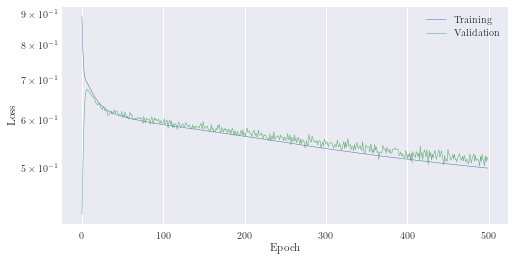

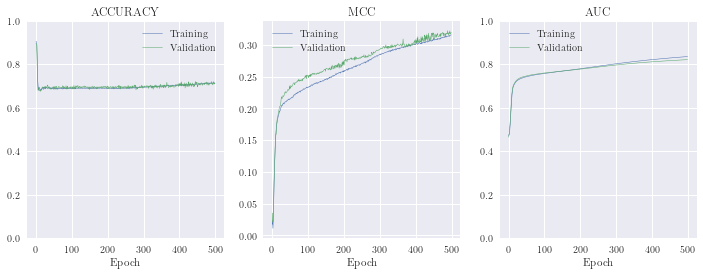

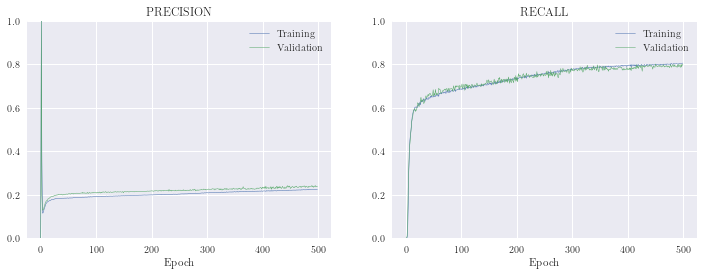

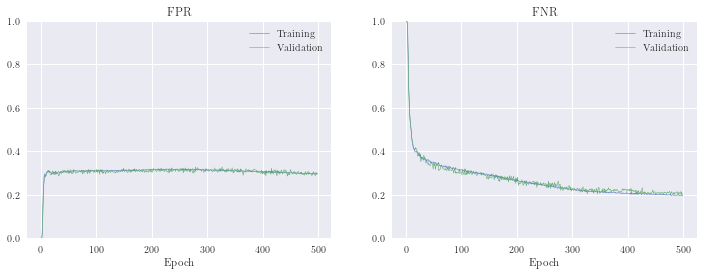

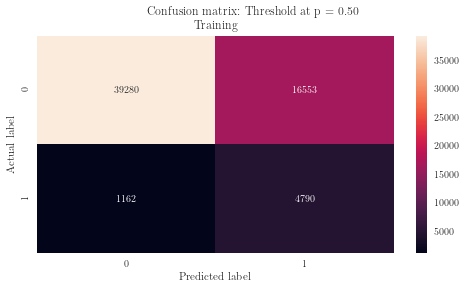

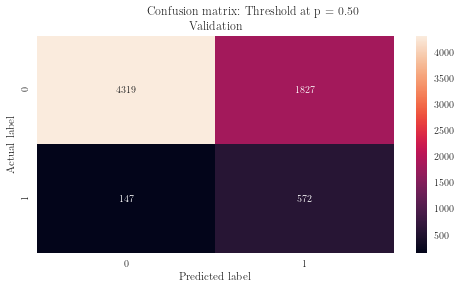

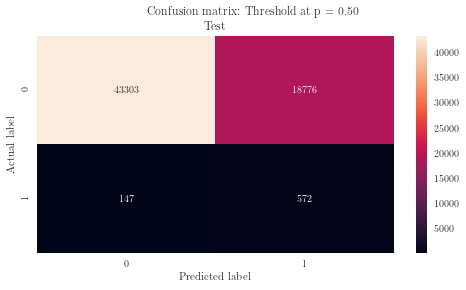

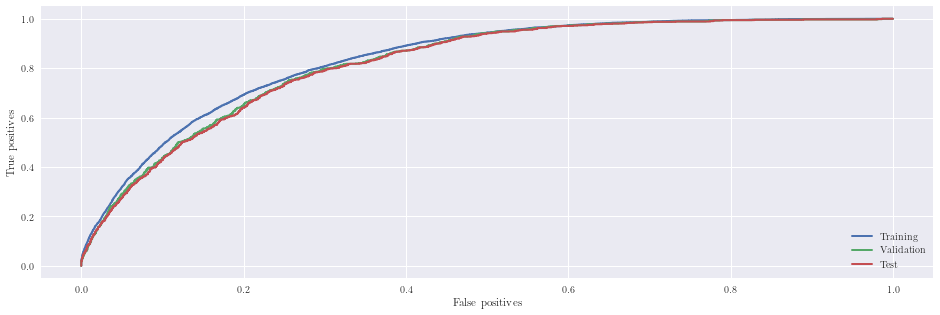

In [31]:
cap.show()

with open(os.path.join(model_dir, "log.txt"), "a") as f:
    f.write(cap.stdout)